# This is  draft version 1 of the notebook used for the data storm 2.0

Import the required modules 



In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from datetime import datetime,timedelta
from imblearn.over_sampling import SMOTE

Read csv to pandas dataframe

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
train= pd.read_csv('/content/gdrive/MyDrive/Data storm 2.0/Data/Hotel-A-train.csv')
validation = pd.read_csv('/content/gdrive/MyDrive/Data storm 2.0/Data/Hotel-A-validation.csv')
test= pd.read_csv('/content/gdrive/MyDrive/Data storm 2.0/Data/Hotel-A-test.csv')

Mounted at /content/gdrive


In [ ]:
train.shape

(27499, 24)

In [ ]:
train.head()

,Reservation-id,Gender,Age,Ethnicity,Educational_Level,Income,Country_region,Hotel_Type,Expected_checkin,Expected_checkout,...,Meal_Type,Visted_Previously,Previous_Cancellations,Deposit_type,Booking_channel,Required_Car_Parking,Reservation_Status,Use_Promotion,Discount_Rate,Room_Rate
0,39428300,F,40,Latino,Grad,<25K,North,City Hotel,7/1/2015,7/2/2015,...,BB,No,No,No Deposit,Online,Yes,Check-In,Yes,10,218
1,77491756,F,49,Latino,Mid-School,50K -- 100K,East,City Hotel,7/1/2015,7/2/2015,...,BB,No,No,Refundable,Online,Yes,Check-In,No,0,185
2,73747291,F,42,caucasian,Grad,<25K,East,City Hotel,7/2/2015,7/6/2015,...,BB,No,No,No Deposit,Online,Yes,Check-In,No,0,119
3,67301739,M,25,African American,College,>100K,South,Airport Hotels,7/2/2015,7/3/2015,...,BB,No,No,Refundable,Agent,Yes,Check-In,Yes,5,144
4,77222321,F,62,Latino,High-School,25K --50K,East,Resort,7/3/2015,7/4/2015,...,BB,No,No,No Deposit,Direct,No,Check-In,Yes,10,242


In [ ]:
train.isnull().sum()

Reservation-id            0
Gender                    0
Age                       0
Ethnicity                 0
Educational_Level         0
Income                    0
Country_region            0
Hotel_Type                0
Expected_checkin          0
Expected_checkout         0
Booking_date              0
Adults                    0
Children                  0
Babies                    0
Meal_Type                 0
Visted_Previously         0
Previous_Cancellations    0
Deposit_type              0
Booking_channel           0
Required_Car_Parking      0
Reservation_Status        0
Use_Promotion             0
Discount_Rate             0
Room_Rate                 0
dtype: int64

In [ ]:
train.dtypes

Reservation-id             int64
Gender                    object
Age                        int64
Ethnicity                 object
Educational_Level         object
Income                    object
Country_region            object
Hotel_Type                object
Expected_checkin          object
Expected_checkout         object
Booking_date              object
Adults                     int64
Children                   int64
Babies                     int64
Meal_Type                 object
Visted_Previously         object
Previous_Cancellations    object
Deposit_type              object
Booking_channel           object
Required_Car_Parking      object
Reservation_Status        object
Use_Promotion             object
Discount_Rate              int64
Room_Rate                  int64
dtype: object

In [ ]:
train['Reservation_Status'].value_counts()

Check-In    21240
Canceled     4134
No-Show      2125
Name: Reservation_Status, dtype: int64

# Functions

Feature enginering  


In [ ]:
def get_month(date):
  return int(date.split('/')[0])

def get_day(date):
  return int(date.split('/')[1])

def get_year(date):
  return int(date.split('/')[2])

def get_week_of_year(date):
  return datetime.strptime(date, "%m/%d/%Y").isocalendar()[1]

def get_days(start,end):
  return (datetime.strptime(end, "%m/%d/%Y").date() -datetime.strptime(start, "%m/%d/%Y").date()).days

def get_day_of_year(date_string):
  return (datetime.strptime(date_string, '%m/%d/%Y')).timetuple().tm_yday

# returns [Friday, Saturday, etc.]
def get_day_of_week(date_string):
  return datetime.strptime(date_string, '%m/%d/%Y').strftime('%A')

def workdays(start, end, excluded=(6, 7)):
  start= datetime.strptime(start, "%m/%d/%Y")
  end= datetime.strptime(end, "%m/%d/%Y")
  days = []
  while start.date() <= end.date():
      if start.isoweekday() not in excluded:
          days.append(start)
      start += timedelta(days=1)
  return len(days)

def weekend_days(start, end, included=(6, 7)):
  start= datetime.strptime(start, "%m/%d/%Y")
  end= datetime.strptime(end, "%m/%d/%Y")
  days = []
  while start.date() <= end.date():
      if start.isoweekday()  in included:
          days.append(start)
      start += timedelta(days=1)
  return len(days)

In [ ]:
train_adr = {
    'City Hotel': {},
    'Airport Hotels': {},
    'Resort': {}
}

validation_adr = {
    'City Hotel': {},
    'Airport Hotels': {},
    'Resort': {}
}

test_adr = {
    'City Hotel': {},
    'Airport Hotels': {},
    'Resort': {}
}

def calculate_adr_per_row(checkin, checkout, hotel_type, room_rate, dictionary):
  day = get_day(checkin)
  month = get_month(checkin)
  year = get_year(checkin)
  days_between = get_days(checkin, checkout)

  for i in range(days_between):
    key = f'{month}/{day+i}/{year}'
    if key in dictionary[hotel_type]:
      dictionary[hotel_type][key]['room_rate'] += room_rate
      dictionary[hotel_type][key]['room_count'] += 1
    else:
      dictionary[hotel_type][key] = {'room_rate': room_rate, 'room_count': 1 }
      
train.apply(lambda x: calculate_adr_per_row(x['Expected_checkin'], x['Expected_checkout'], x['Hotel_Type'], x['Room_Rate'], train_adr), axis=1)
validation.apply(lambda x: calculate_adr_per_row(x['Expected_checkin'], x['Expected_checkout'], x['Hotel_Type'], x['Room_Rate'], validation_adr), axis=1)
test.apply(lambda x: calculate_adr_per_row(x['Expected_checkin'], x['Expected_checkout'], x['Hotel_Type'], x['Room_Rate'], test_adr), axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
4313    None
4314    None
4315    None
4316    None
4317    None
Length: 4318, dtype: object

In [ ]:
def get_adr(date, hotel_type, mode=''):
  try:
    if (mode=='val'):
      return validation_adr[hotel_type][date]['room_rate']/validation_adr[hotel_type][date]['room_count']
    elif mode == 'test':
      return test_adr[hotel_type][date]['room_rate']/test_adr[hotel_type][date]['room_count']
    return train_adr[hotel_type][date]['room_rate']/train_adr[hotel_type][date]['room_count']
  except Exception as e:
    print(mode, 'mode')
    print(e,mode)
    return 0

In [ ]:
def get_room_count(date, hotel_type, mode=''):
  try:
    if (mode=='val'):
      return validation_adr[hotel_type][date]['room_count']
    elif mode == 'test':
      return test_adr[hotel_type][date]['room_count']
    return train_adr[hotel_type][date]['room_count']
  except Exception as e:
    print(mode, 'mode')
    print(e,mode)
    return 0

In [ ]:
def feature_eng(df,mode=''):
  df['ADR']=df.apply(lambda x:get_adr(x['Expected_checkin'],x['Hotel_Type'],mode=mode),axis=1)
  df['rooms_occupied']=df.apply(lambda x:get_room_count(x['Expected_checkin'],x['Hotel_Type'],mode=mode),axis=1)
  df['Expected_duration']=df.apply(lambda x:get_days(x['Expected_checkin'],x['Expected_checkout']),axis=1)
  df['Expected_weekdays']=df.apply(lambda x:workdays(x['Expected_checkin'],x['Expected_checkout']),axis=1)
  df['Expected_weekends']=df.apply(lambda x:weekend_days(x['Expected_checkin'],x['Expected_checkout']),axis=1)
  df['No_of_date_between_booking_date_expected_checkin']=df.apply(lambda x:get_days(x['Booking_date'],x['Expected_checkin']),axis=1)
  df['No_of_date_between_booking_date_expected_checkout']=df.apply(lambda x:get_days(x['Booking_date'],x['Expected_checkout']),axis=1)
  df['Expected_checkin_month']=df.apply(lambda x:get_month(x['Expected_checkin']),axis=1)
  df['Expected_checkout_month']=df.apply(lambda x:get_month(x['Expected_checkout']),axis=1)
  df['Booking_date_month']=df.apply(lambda x:get_month(x['Booking_date']),axis=1)
  df['Expected_checkin_year']=df.apply(lambda x:get_year(x['Expected_checkin']),axis=1)
  df['Expected_checkout_year']=df.apply(lambda x:get_year(x['Expected_checkout']),axis=1)
  df['Booking_date_year']=df.apply(lambda x:get_year(x['Booking_date']),axis=1)
  df['Expected_checkin_date']=df.apply(lambda x:get_day(x['Expected_checkin']),axis=1)
  df['Expected_checkout_date']=df.apply(lambda x:get_day(x['Expected_checkout']),axis=1)
  df['Booking_date_date']=df.apply(lambda x:get_day(x['Booking_date']),axis=1)
  df['Expected_checkin_week']=df.apply(lambda x:get_week_of_year(x['Expected_checkin']),axis=1)
  df['Expected_checkout_week']=df.apply(lambda x:get_week_of_year(x['Expected_checkout']),axis=1)
  df['Booking_date_week']=df.apply(lambda x:get_week_of_year(x['Booking_date']),axis=1)
  df=df.drop(['Expected_checkin', 'Expected_checkout','Booking_date'], axis = 1) 
  return df

change columns data types

In [ ]:
gender_mapping = {"F":1, "M":2}
education_level_mapping = {"Mid-School":1, "High-School":2,"College":3,"Grad":4}
income_mapping={"<25K":1,"25K --50K":2,"50K -- 100K":3,">100K":4}
meal_mapping={"BB":1,"HB":2,"FB":3}
deposite_mapping={"No Deposit":1,"Refundable":2,"Non-Refundable":3}
reservation_mapping={"Check-In":1,"Canceled":2,"No-Show":3}
boolean_mapping={"Yes":1,"No":0}
def mapping(df,mode=""):
  df["Gender_Enc"] = df["Gender"].replace(gender_mapping)
  df["Educational_Level_Enc"] = df["Educational_Level"].replace(education_level_mapping)
  df["Income_Enc"] = df["Income"].replace(income_mapping)
  df["Meal_Type_Enc"] = df["Meal_Type"].replace(meal_mapping)
  df["Deposit_type_EnC"] = df["Deposit_type"].replace(deposite_mapping)
  if(mode !='test'):
    df["Reservation_Status_Enc"] = df["Reservation_Status"].replace(reservation_mapping)
  df["Visted_Previously_Enc"] = df["Visted_Previously"].replace(boolean_mapping)
  df["Required_Car_Parking_Enc"] = df["Required_Car_Parking"].replace(boolean_mapping)
  df["Previous_Cancellations_Enc"] = df["Previous_Cancellations"].replace(boolean_mapping)
  df["Use_Promotion_Enc"] = df["Use_Promotion"].replace(boolean_mapping)
  col=['Gender', 'Educational_Level','Income','Meal_Type','Deposit_type','Reservation_Status','Visted_Previously','Required_Car_Parking','Previous_Cancellations','Use_Promotion','Reservation-id']
  if(mode=='test'):
    col.remove('Reservation_Status')
  df=df.drop(col, axis = 1) 
  return df

use oneHotEncoder

In [ ]:
def oneHotEncoder(df):
  return pd.get_dummies(data=df, columns=['Ethnicity','Country_region', 'Hotel_Type','Booking_channel'])

Preprocessor

In [ ]:
def preprocessor(df,mode=""):
  df=feature_eng(df,mode=mode)
  df= mapping(df,mode=mode)
  df=oneHotEncoder(df)
  cols_to_norm=df.columns.to_list()
  if(mode=="test"):
    scaler= MinMaxScaler()
    df[cols_to_norm]= scaler.fit_transform(df[cols_to_norm])
    return df
  cols_to_norm.remove('Reservation_Status_Enc')
  scaler= MinMaxScaler()
  df[cols_to_norm]= scaler.fit_transform(df[cols_to_norm])
  X= df.drop('Reservation_Status_Enc',axis=1)
  y=df['Reservation_Status_Enc']
  return (X,y,df)

In [ ]:
def getBalancedData(X, y):
    smote = SMOTE()
    X, y = smote.fit_resample(X, y)
    return X, y

Visulaization

In [ ]:
train_X, train_y, train_df= preprocessor(train)

In [ ]:
train_df.skew()

Age                                                  0.003686
Adults                                               0.860928
Children                                             0.428316
Babies                                               1.399147
Discount_Rate                                        0.716332
Room_Rate                                           -0.000533
ADR                                                 -0.061527
rooms_occupied                                       0.191319
Expected_duration                                    0.855781
Expected_weekdays                                    0.257352
Expected_weekends                                    0.485310
No_of_date_between_booking_date_expected_checkin     0.799717
No_of_date_between_booking_date_expected_checkout    0.800566
Expected_checkin_month                               0.051554
Expected_checkout_month                              0.044349
Booking_date_month                                  -0.125381
Expected

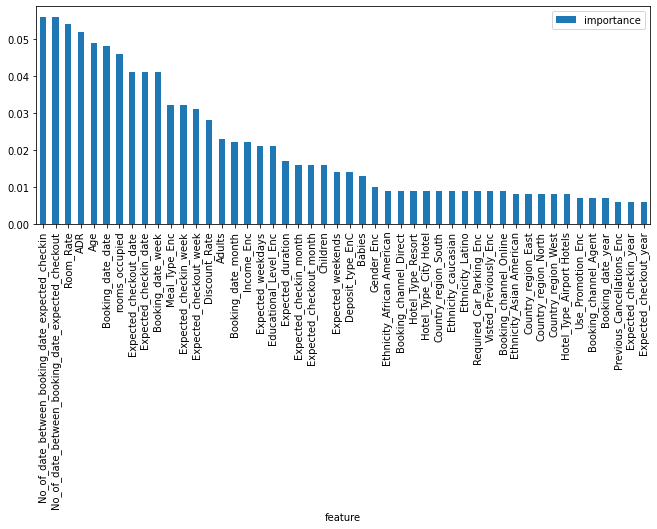

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
train_X, train_y,train_df= preprocessor(train)
rfc.fit(train_X, train_y);

# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_X.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [ ]:
from sklearn.feature_selection import RFE
import itertools
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(train_X, train_y)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), train_X.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

In [ ]:
train_X = train_X[['Age',
 'Room_Rate',
 'ADR',
 'rooms_occupied',
 'No_of_date_between_booking_date_expected_checkin',
 'No_of_date_between_booking_date_expected_checkout',
 'Expected_checkin_date',
 'Expected_checkout_date',
 'Booking_date_date',
 'Booking_date_week']]
# balanced_train_X, balanced_train_y = getBalancedData(train_X, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Model evaluation

In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=400)),
               ("XT_model",ExtraTreesClassifier()),
#                ("LR_model", LogisticRegression(random_state=42,n_jobs=-1,max_iter=250)),
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1)),
#                ("MLP_model",MLPClassifier(random_state=42)),
#                ("Knn_model",KNeighborsClassifier(n_neighbors=3)),
#                ("CatBoost",CatBoostClassifier(n_estimators=400)),
               ("NB_model",GaussianNB()),
               ("LDA_model",LinearDiscriminantAnalysis())]

for name, model in (base_models):
  scores = cross_val_score(model, balanced_train_X, balanced_train_y, scoring='f1_macro', cv=cv, n_jobs=-1)
  print(f"{name} F1 Score: {round(np.mean(scores),4), round(np.std(scores),4)}")

In [ ]:
from sklearn.metrics import f1_score, classification_report, plot_confusion_matrix,confusion_matrix,homogeneity_completeness_v_measure,accuracy_score,adjusted_rand_score
validation_X,validation_y,validation_df= preprocessor(validation,mode='val')
validation_X = validation_X[['Age',
 'Room_Rate',
 'ADR',
 'rooms_occupied',
 'No_of_date_between_booking_date_expected_checkin',
 'No_of_date_between_booking_date_expected_checkout',
 'Expected_checkin_date',
 'Expected_checkout_date',
 'Booking_date_date',
 'Booking_date_week']]
model=DecisionTreeClassifier()
model.fit(train_X,train_y)
pred=model.predict(validation_X)
acc= accuracy_score(validation_y,pred)
fscore=f1_score(validation_y,pred,average="macro")
print(acc,fscore)
print(classification_report(validation_y,pred))

0.5383775918515824 0.3090326927042701
              precision    recall  f1-score   support

           1       0.59      0.86      0.70      1610
           2       0.30      0.09      0.14       741
           3       0.15      0.06      0.09       398

    accuracy                           0.54      2749
   macro avg       0.35      0.34      0.31      2749
weighted avg       0.45      0.54      0.46      2749



In [ ]:

test_X = preprocessor(test,mode='test')
test_X = test_X[['Age',
 'Room_Rate',
 'ADR',
 'rooms_occupied',
 'No_of_date_between_booking_date_expected_checkin',
 'No_of_date_between_booking_date_expected_checkout',
 'Expected_checkin_date',
 'Expected_checkout_date',
 'Booking_date_date',
 'Booking_date_week']]
y_pred = model.predict(test_X)

In [ ]:
submission = pd.DataFrame({'Reservation-id':test['Reservation-id'],'Reservation_status':y_pred})
submission.head(5)

,Reservation-id,Reservation_status
0,62931593,3
1,70586099,1
2,4230648,2
3,25192322,1
4,80931528,3


In [ ]:
submission.to_csv('./submission-1.csv',index=False)